In [1]:
import numpy as np
import pandas as pd
import os

from PIL import Image
import xml.etree.ElementTree as ET
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torch
from math import log2

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torchvision.utils as vutils

import time
import tqdm

In [2]:
# show images
def show_tensor_images(image_tensor, num_images = 16, size=(3, 64, 64), nrows = 4):
    image_tensor = (image_tensor + 1)/2
    image_unflat = image_tensor.detach().cpu().clamp_(0, 1)
    image_grid = make_grid(image_unflat[:num_images], nrow = nrows, padding=0)
    plt.imshow(image_grid.permute(1,2,0).squeeze())
    plt.axis('off')
    plt.show()

In [3]:
# truncation trick
from scipy.stats import truncnorm

def get_trunc_noise(n_samples, z_dim, truncation):
    trunc_noise = truncnorm.rvs(-truncation, truncation, size = (n_samples, z_dim))
    return torch.Tensor(trunc_noise)

In [24]:
class WSLinear(nn.Module):
    def __init__(
        self, in_features, out_features,
    ):
        super(WSLinear, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.scale = (2 / in_features)**0.5
        self.bias = self.linear.bias
        self.linear.bias = None

        # initialize linear layer
        nn.init.normal_(self.linear.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        return self.linear(x * self.scale) + self.bias

In [25]:
class WSConv2d(nn.Module):
    def __init__(
        self, in_channels, out_channels, kernel_size=3, stride=1, padding=1
    ):
        super(WSConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.scale = (2 / (in_channels * (kernel_size ** 2))) ** 0.5
        self.bias = self.conv.bias
        self.conv.bias = None

        # initialize conv layer
        nn.init.normal_(self.conv.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        return self.conv(x * self.scale) + self.bias.view(1, self.bias.shape[0], 1, 1)

In [4]:
z = get_trunc_noise(10, 10, 0.8)

In [26]:
# Mapping layers
class MappingLayers(nn.Module):
    def __init__(self, z_dim, hidden_dim, w_dim):
        super().__init__()
        self.mapping = nn.Sequential(
            WSLinear(z_dim,hidden_dim),
            nn.ReLU(),
            WSLinear(hidden_dim,hidden_dim),
            nn.ReLU(),
            WSLinear(hidden_dim, w_dim)
        )
        
    def forward(self, noise):
        return self.mapping(noise)
    
    def get_mapping(self):
        return self.mapping

In [27]:
mappinglayers = MappingLayers(10,10,20)
w = mappinglayers.forward(z)

In [28]:
# InjectNoise
class InjectNoise(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.weight = nn.Parameter(
            torch.randn(channels)[None, :, None, None]
        )
        
    def forward(self, image):
        noise_shape = (image.shape[0], 1, image.shape[2], image.shape[3])
        noise = torch.randn(noise_shape, device = image.device)
        return image + self.weight*noise
    
    def get_weight(self):
        return self.weight
    
    def get_self(self):
        return

In [29]:
# AdalN
class AdaIN(nn.Module):
    def __init__(self,channels,w_dim):
        super().__init__()
        self.instance_norm = nn.InstanceNorm2d(channels)
        self.style_scale_transform = WSLinear(w_dim, channels)
        self.style_shift_transform = WSLinear(w_dim, channels)
        
    def forward(self, image, w):
        normalized_image = self.instance_norm(image)
        style_scale = self.style_scale_transform(w)[:,:,None,None]
        style_shifts = self.style_shift_transform(w)[:,:,None,None]
        
        transformed_image = style_scale * normalized_image + style_shifts
        return transformed_image
    
    def get_style_scale_transform(self):
        return self.style_scale_transform
    
    def get_style_shift_transform(self):
        return self.style_shift_transform
    
    def get_self(self):
        return self

In [30]:
class StyleGANGeneratorBlock(nn.Module):
    def __init__(self, in_chan, out_chan, w_dim, kernel_size, not_initial=True):
        super().__init__()
        self.not_initial = not_initial
        self.conv1 = WSConv2d(in_chan, out_chan, kernel_size=kernel_size)
        self.conv2 = WSConv2d(out_chan, out_chan, kernel_size=kernel_size)
        self.inject_noise1 = InjectNoise(out_chan)
        self.inject_noise2 = InjectNoise(out_chan)
        self.adain1 = AdaIN(out_chan, w_dim)
        self.adain2 = AdaIN(out_chan, w_dim)
        self.activation = nn.LeakyReLU(0.2)
        
    def forward(self, x, w):
        if self.not_initial:
            x = self.conv1(x)
        x = self.inject_noise1(x)
        x = self.adain1(x,w)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.inject_noise2(x)
        x = self.adain2(x,w)
        x = self.activation(x)
        return x
    
    def get_self(self):
        return self

In [31]:
for x in range(0,9,1):
    print(x)

0
1
2
3
4
5
6
7
8


In [32]:
factor = [1,1,1,1/2,1/4]

In [33]:
class StyleGANGenerator(nn.Module):
    def __init__(self,
                z_dim,
                map_hidden_dim,
                w_dim,
                in_chan,
                out_chan,
                kernel_size,
                hidden_chan):
        super().__init__()
        self.map = MappingLayers(z_dim, map_hidden_dim, w_dim)
        self.starting_constant = nn.Parameter(torch.randn(1, in_chan, 4, 4))
        self.initial_rgb = WSConv2d(in_chan, out_chan, kernel_size = 1, stride = 1, padding = 0)
        self.initial_block = StyleGANGeneratorBlock(in_chan, in_chan,w_dim, kernel_size,not_initial=False)
        # progressive block
        self.prog_blocks, self.rgb_layers = (nn.ModuleList([]), nn.ModuleList([self.initial_rgb]),)
        
        for i in range(len(factor)-1):
            conv_in_chan = int(in_chan*factor[i])
            conv_out_chan = int(in_chan*factor[i+1])
            self.prog_blocks.append(StyleGANGeneratorBlock(conv_in_chan, conv_out_chan, w_dim, kernel_size))
            self.rgb_layers.append(WSConv2d(conv_out_chan, out_chan, kernel_size=1, stride= 1, padding = 0))
        
        
    def upsample_to_match_size(self, smaller_image, bigger_image):
        return F.interpolate(smaller_image, size = bigger_image.shape[-2:], mode='bilinear')
    
    def forward(self, noise, alpha, steps, return_intermediate=False):
        x = self.starting_constant
        w = self.map(noise)
        out = self.initial_block(x,w)
        
        if steps == 0:
            return self.initial_rgb(out)
        
        for step in range(int(steps)):
            upscaled = F.interpolate(out, scale_factor=2, mode="bilinear")
            out = self.prog_blocks[step](upscaled, w)
        
        final_upscaled = self.rgb_layers[steps-1](upscaled)
        final_out = self.rgb_layers[steps](out)
        
        interpolation = alpha*(final_out) + (1-alpha)*(final_upscaled)
        
        if return_intermediate:
            return interpolation, final_upscaled, final_out
        else:
            return interpolation
        
    def get_self(self):
        return self
        

In [38]:
z_dim = 128
out_chan = 3
truncation = 0.7

mu_stylegan = StyleGANGenerator(
    z_dim=z_dim, 
    map_hidden_dim=1024,
    w_dim=496,
    in_chan=512,
    out_chan=out_chan, 
    kernel_size=3, 
    hidden_chan=256
)

test_samples = 10
test_result = mu_stylegan(get_trunc_noise(test_samples, z_dim, truncation),0.2, steps = 4)

# Check if the block works
assert tuple(test_result.shape) == (test_samples, out_chan, 64, 64)

# Check that the interpolation is correct
mu_stylegan.alpha = 1.
test_result, _, test_big =  mu_stylegan(
    get_trunc_noise(test_samples, z_dim, truncation), 1,steps = 3,
    return_intermediate=True)
assert torch.abs(test_result - test_big).mean() < 0.001
mu_stylegan.alpha = 0.
test_result, test_small, _ =  mu_stylegan(
    get_trunc_noise(test_samples, z_dim, truncation),0.0001, steps = 4, 
    return_intermediate=True)
assert torch.abs(test_result - test_small).mean() < 0.001
print("Success!")

Success!


In [39]:
test_result.shape

torch.Size([10, 3, 64, 64])

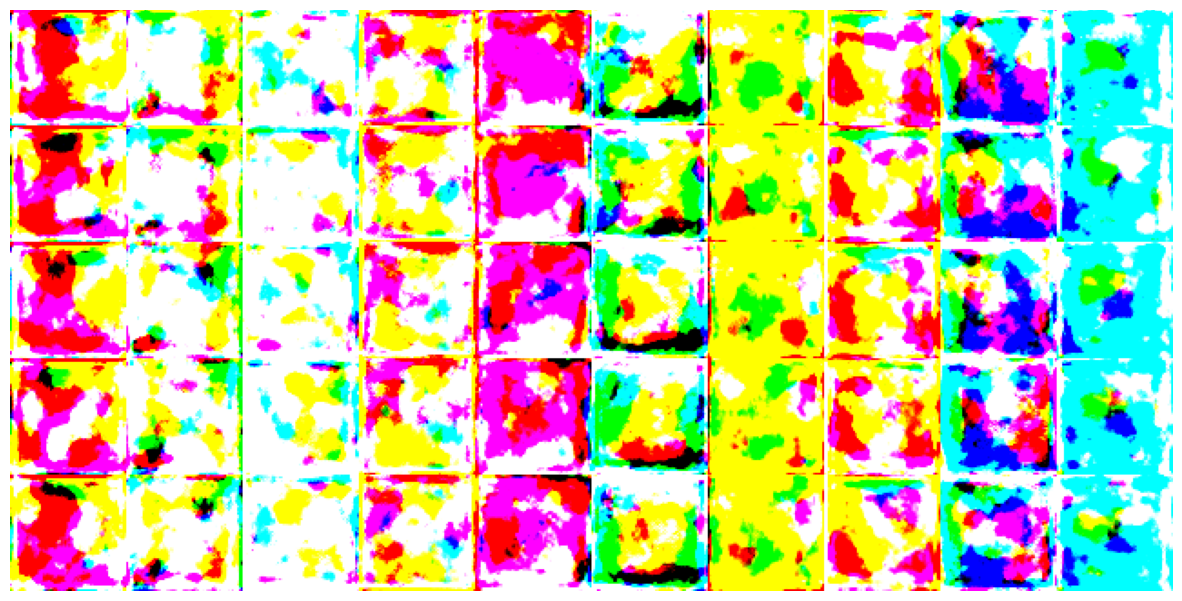

In [40]:
import numpy as np
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 15]

viz_samples = 10
# The noise is exaggerated for visual effect
viz_noise = get_trunc_noise(viz_samples, z_dim, truncation) * 10

mu_stylegan.eval()
images = []
for alpha in np.linspace(0, 1, num=5):
    mu_stylegan.alpha = alpha
    viz_result, _, _ =  mu_stylegan(
        viz_noise, 0.2,steps = 4, 
        return_intermediate=True)
    images += [tensor for tensor in viz_result]
show_tensor_images(torch.stack(images), num_images=len(images),nrows=viz_samples)
mu_stylegan = mu_stylegan.train()

In [42]:
class disc_block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1):
        super().__init__()
        self.conv1 = WSConv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.conv2 = WSConv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.activation = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        x = self.activation(self.conv1(x))
        x = self.activation(self.conv2(x))
        return x

In [43]:
class StyleDiscriminator(nn.Module):
    def __init__(self, in_chan, im_chan=3):
        super().__init__()
        self.prog_blocks, self.rgb_layers = (nn.ModuleList([]), nn.ModuleList([]),)
        self.activation = nn.LeakyReLU(0.2)

        for i in range(len(factor)-1, 0, -1):
            conv_in_chan = int(in_chan * factor[i])
            conv_out_chan = int(in_chan * factor[i-1])
            self.prog_blocks.append(disc_block(conv_in_chan, conv_out_chan))
            self.rgb_layers.append(WSConv2d(im_chan, conv_in_chan, kernel_size=1, stride = 1, padding = 0))

        self.initial_rgb = WSConv2d(im_chan, in_chan, kernel_size=1, stride = 1, padding = 0)
        self.rgb_layers.append(self.initial_rgb)
        self.avg_pool = nn.AvgPool2d(kernel_size = 2, stride = 2)
        self.final_block = nn.Sequential(WSConv2d(in_chan+1, in_chan, kernel_size=3, padding=1),
                                         nn.LeakyReLU(0.2),
                                         WSConv2d(in_chan, in_chan, kernel_size=4, padding=0, stride=1),
                                         nn.LeakyReLU(0.2),
                                         WSConv2d(in_chan, 1, kernel_size=1, padding=0, stride=1))
    
    def minibatch_std(self, x):
        batch_stat = (torch.std(x,dim=0).mean().repeat(x.shape[0],1,x.shape[2],x.shape[3]))
        return torch.cat([x,batch_stat], dim = 1)
        
    def forward(self,x, alpha, steps):
        cur_step = len(self.prog_blocks) - steps
        out = self.activation(self.rgb_layers[cur_step](x))
        if steps == 0:
            out = self.minibatch_std(out)
            return self.final_block(out).view(out.shape[0],-1)
        downscaled = self.activation(self.rgb_layers[cur_step+1](self.avg_pool(x)))
        out = self.avg_pool(self.prog_blocks[cur_step](out))
        out = alpha * out + (1-alpha) * downscaled
        
        for step in range(cur_step + 1, len(self.prog_blocks)):
            out = self.prog_blocks[step](out)
            out = self.avg_pool(out)
        out = self.minibatch_std(out)
        return self.final_block(out).view(out.shape[0],-1)
        

In [44]:
disc = StyleDiscriminator(in_chan=512)

In [45]:
disc.forward(test_result,0.2,4)

tensor([[ 0.0848],
        [ 0.2232],
        [ 0.0685],
        [ 0.2524],
        [ 0.3762],
        [ 0.0087],
        [ 0.2045],
        [-0.0179],
        [ 0.2345],
        [ 0.4689]], grad_fn=<ViewBackward0>)

In [22]:
breed_list = os.listdir("../input/stanford-dogs-dataset/images/Images/")
num_classes = len(breed_list)
print("{} breeds".format(num_classes))

120 breeds


In [23]:
# collect all the photos into one folder
os.makedirs('all_dog_images_1/dummy_flie/',exist_ok = True)
for breed in breed_list:
    for file in os.listdir('../input/stanford-dogs-dataset/annotations/Annotation/{}'.format(breed)):
        img = Image.open('../input/stanford-dogs-dataset/images/Images/{}/{}.jpg'.format(breed, file))
        tree = ET.parse('../input/stanford-dogs-dataset/annotations/Annotation/{}/{}'.format(breed, file))
        xmin = int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
        xmax = int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
        ymin = int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
        ymax = int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)
        img = img.crop((xmin, ymin, xmax, ymax))
        img = img.convert('RGB')
        img.save('all_dog_images_1/' +'dummy_flie/'+ file + '.jpg')

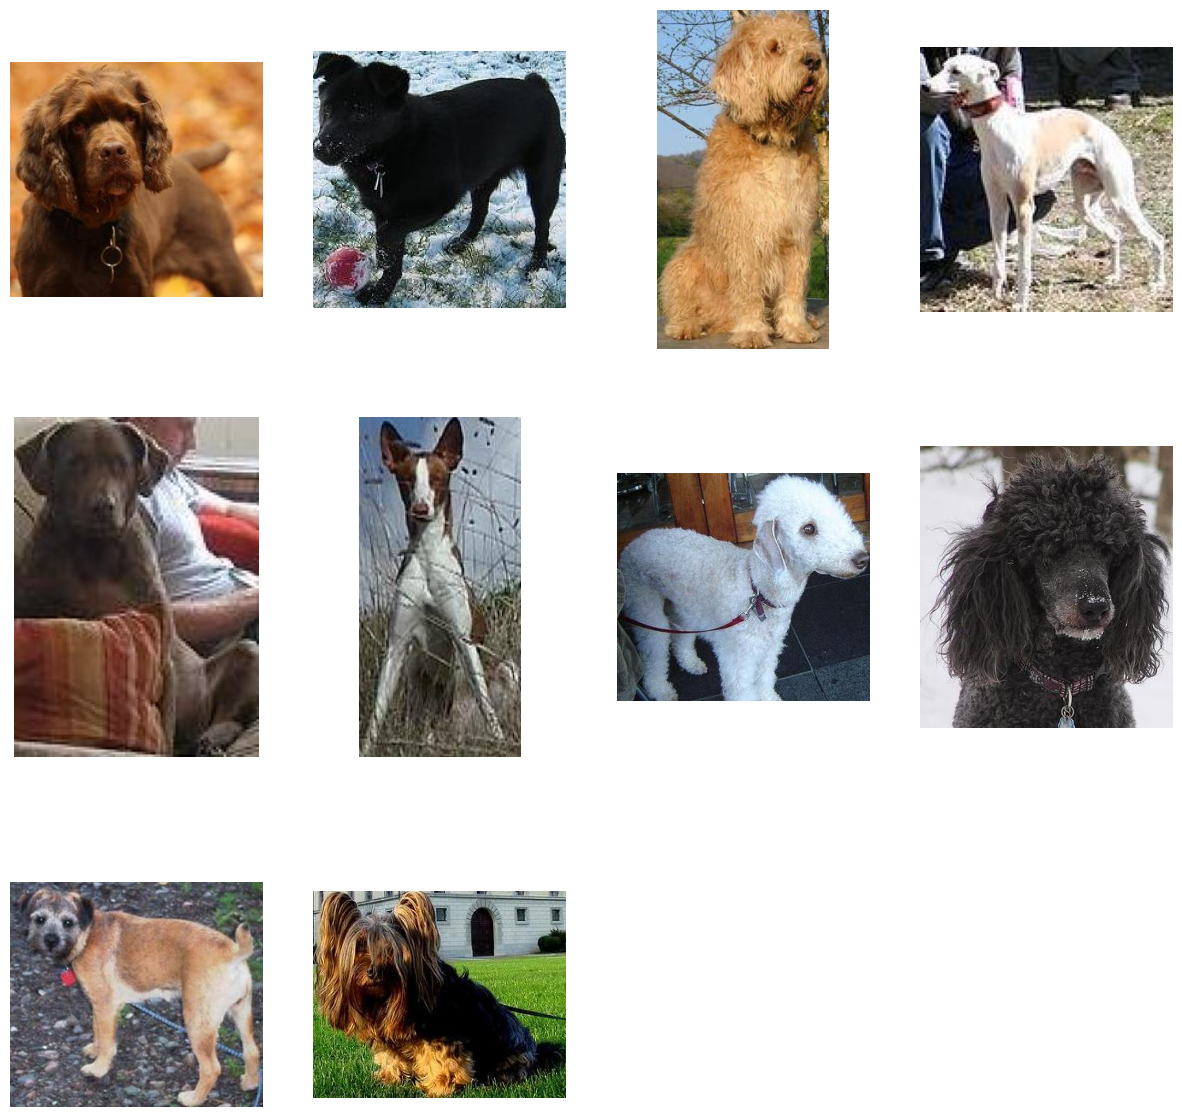

In [46]:
images = os.listdir('all_dog_images_1/dummy_flie/')[0:10]
for i in range(10):
        img = mpimg.imread('all_dog_images_1/dummy_flie/'+images[i])
        plt.subplot(int(10/4)+1, 4, i+1)
        plt.imshow(img)
        plt.axis('off')

In [47]:
# batch_size = 32
image_size = 64

image_transform = transforms.Compose([
    transforms.Resize((image_size,image_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data = ImageFolder('all_dog_images_1/',transform=image_transform)
# train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size = batch_size)

# imgs, label = next(iter(train_loader))
num_data = len(train_data)

In [48]:
def get_loader(img_size):
    image_transform = transforms.Compose([
        transforms.Resize((img_size,img_size)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    batch_size = BATCH_SIZE[int(log2(img_size/4))]
    train_data = ImageFolder('all_dog_images_1/',transform=image_transform)
    train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size = batch_size)
    
    return train_loader

In [49]:
get_loader(64)

NameError: name 'BATCH_SIZE' is not defined

In [50]:
# imgs = imgs.numpy().transpose(0, 2, 3, 1)
# for i in range(5):
#     plt.imshow(imgs[i])
#     plt.show()

In [51]:
!mkdir results
!ls

all_dog_images_1  results


In [52]:
!rm results

rm: cannot remove 'results': Is a directory


In [53]:
BATCH_SIZE = [256, 128, 64, 32,32]

EPOCH = 10 # play with me

lr_G = 0.001
lr_D = 0.0005
lambda_gp = 10
progressive_epoch = [30]*len(BATCH_SIZE)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

z_dim = 128
truncation = 0.7

cuda


In [54]:
Gen = StyleGANGenerator(
    z_dim=z_dim, 
    map_hidden_dim=1024,
    w_dim=496,
    in_chan=512,
    out_chan=out_chan, 
    kernel_size=3, 
    hidden_chan=256
).to(device)
Disc = StyleDiscriminator(in_chan=512).to(device)
optimizerG = torch.optim.Adam([{"params": [param for name, param in Gen.named_parameters() if "map" not in name]},{"params": Gen.map.parameters(), "lr": 1e-5}], lr=lr_G, betas=(0.0, 0.999))
optimizerD = torch.optim.Adam(Disc.parameters(), lr=lr_D, betas=(0.0, 0.999))

In [55]:
Gen.train()
Disc.train()

StyleDiscriminator(
  (prog_blocks): ModuleList(
    (0): disc_block(
      (conv1): WSConv2d(
        (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (conv2): WSConv2d(
        (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (activation): LeakyReLU(negative_slope=0.2)
    )
    (1): disc_block(
      (conv1): WSConv2d(
        (conv): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (conv2): WSConv2d(
        (conv): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (activation): LeakyReLU(negative_slope=0.2)
    )
    (2-3): 2 x disc_block(
      (conv1): WSConv2d(
        (conv): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (conv2): WSConv2d(
        (conv): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    

In [56]:
def gradient_penalty(Disc, real, fake, alpha, train_step, device="cpu"):
    N, C, H, W = real.shape
    beta = torch.rand((N,1,1,1)).repeat(1,C,H,W).to(device)
    interpolated_image = real*beta + fake.detach()*(1-beta)
    interpolated_image.requires_grad_(True)
    # calculate critic score
    mixed_scores = Disc(interpolated_image, alpha, train_step)
    
    gradient = torch.autograd.grad(
        inputs=interpolated_image,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True
    )[0]
    gradient = gradient.view(gradient.shape[0],-1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm-1)**2)
    return gradient_penalty

In [57]:
from torchvision.utils import save_image
def generate_examples(gen, steps, n=100):

    gen.eval()
    alpha = 1.0
    for i in range(n):
        with torch.no_grad():
            noise = torch.randn(1, z_dim).to(device)
            img = gen(noise, alpha, steps)
            if not os.path.exists(f'saved_examples/step{steps}'):
                os.makedirs(f'saved_examples/step{steps}')
            save_image(img*0.5+0.5, f"saved_examples/step{steps}/img_{i}.png")
    gen.train()

In [58]:
def train(
    Disc,
    Gen,
    loader,
    step,
    alpha,
    opt_disc,
    opt_gen
):
    loop = tqdm.tqdm(loader, leave=True)
    for idx, (real,_) in enumerate(loop):
        real = real.to(device)
        cur_batch_size = real.shape[0]
        noise = get_trunc_noise(cur_batch_size, z_dim, truncation).to(device)
        fake = Gen(noise,alpha,step)
        critic_real = Disc(real, alpha, step)
        critic_fake = Disc(fake.detach(), alpha, step)
        print(fake.shape,real.shape)
        gp = gradient_penalty(Disc, real, fake, alpha, step, device=device)
        loss_critic = (-(torch.mean(critic_real) - torch.mean(critic_fake)) + lambda_gp * gp + (0.001*torch.mean(critic_real **2)))
        Disc.zero_grad()
        loss_critic.backward()
        opt_disc.step()
        
        gen_fake = Disc(fake, alpha, step)
        loss_gen = -torch.mean(gen_fake)
        
        Gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()
        
        # Update alpha and ensure less than 1
        alpha += cur_batch_size / (
            (progressive_epoch[step] * 0.5) * num_data
        )
        alpha = min(alpha, 1)
        if idx // 20 == 0:
            loop.set_postfix(
                gp=gp.item(),
                loss_critic=loss_critic.item(),
            )

    return alpha

In [61]:
generate_examples(Gen, step)

In [1]:
step = int(log2(8 / 4))
for num_epochs in progressive_epoch[step:]:
    alpha = 1e-5   # start with very low alpha
    loader= get_loader(4 * 2 ** step)  
    print(f"Current image size: {4 * 2 ** step}")

    for epoch in range(num_epochs):
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        alpha = train(
            Disc,
            Gen,
            loader,
            step,
            alpha,
            optimizerD,
            optimizerG
        )

    generate_examples(Gen, step)
    step += 1  # progress to the next img size


In [ ]:
fig = plt.figure(figsize=(25, 16))
# display 10 images from each class
for i, j in enumerate(images[:32]):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    plt.imshow(j)

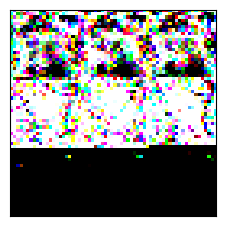

In [75]:
Gen.eval()
fig = plt.figure(figsize=(25, 16))
alpha = 1.0
#for i in range(8):
with torch.no_grad():
    noise = torch.randn(1, z_dim).to(device)
    img = Gen(noise, alpha, 4)
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    plt.imshow(img.to("cpu").numpy().reshape(1,64,64,3).squeeze())

### images = os.listdir('results')
img = mpimg.imread('results/'+images[2])
plt.imshow(img)
plt.axis('off')

In [ ]:
# import os
# import zipfile
# import datetime

# def file2zip(packagePath, zipPath):
#     '''
#   :param packagePath: 文件夹路径
#   :param zipPath: 压缩包路径
#   :return:
#   '''
#     zip = zipfile.ZipFile(zipPath, 'w', zipfile.ZIP_DEFLATED)
#     for path, dirNames, fileNames in os.walk(packagePath):
#         fpath = path.replace(packagePath, '')
#         for name in fileNames:
#             fullName = os.path.join(path, name)
#             name = fpath + '\\' + name
#             zip.write(fullName, name)
#     zip.close()


# if __name__ == "__main__":
#     # 文件夹路径
#     packagePath = '/kaggle/working/results'
#     zipPath = '/kaggle/working/output.zip'
#     if os.path.exists(zipPath):
#         os.remove(zipPath)
#     file2zip(packagePath, zipPath)
#     print("打包完成")
#     print(datetime.datetime.utcnow())